<a href="https://colab.research.google.com/github/amandasbassani/Notebooks_Visao_Computacional/blob/main/T2_Vis%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T2 - Função para estimar a Homografia (Visão Computacional - 2022/1)

Amanda Schneider Bassani



## Funções

In [1]:
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.5 MB 70 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55.7 MB 1.2 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2 as cv
import random

### Normalização

In [4]:
# Função para normalizar pontos
# Entrada: points (pontos da imagem a serem normalizados)
# Saída: norm_points (pontos normalizados)
#        T (matriz de normalização)
def normalize_points(points):
    total_points = points.shape[1]
    center = np.mean(points[:2], axis=1)


    # Scale to a √2 average distance to the origin
    sum_distances = sum(np.sqrt((points[0,:] - center[0])**2 + (points[1,:] - center[1])**2))
    average_distance = sum_distances/total_points
    esc = np.sqrt(2)/average_distance
   # esc = np.sqrt(2)/np.std(points[:2])

    T = np.array([[esc, 0, -esc*center[0]],
                  [0, esc, -esc*center[1]],
                  [ 0, 0, 1]])
    norm_points = np.dot(T,points)    
    
    return norm_points, T

### Matriz A empilhada

In [5]:

# Função para montar a matriz A do sistema de equações do DLT e empilhar as matrizes A(i)
# Entrada: pts1, pts2 (pontos "pts1" da primeira imagem e pontos "pts2" da segunda imagem que atendem a pts2=H.pts1)
# Saída: A_empilhada (matriz com as 2 linhas resultantes da relação pts2 x H.pts1 = 0 para cada ponto (2*n x 9))
def compute_A(pts1, pts2):
    A = []
    for i in range(pts1.shape[1]):
        x = pts2[0][i]*pts1[:,i]
        y = pts2[1][i]*pts1[:,i]
        w = pts2[2][i]*pts1[:,i]
        Ai = np.matrix([[0, 0, 0, -w[0], -w[1], -w[2], y[0], y[1], y[2]],
                        [w[0], w[1], w[2], 0, 0, 0, -x[0], -x[1], -x[2]]])
        A.append(Ai)
    A = np.array(A)
    A_empilhada = np.reshape(A, (2*pts1.shape[1],9))

    return A_empilhada

### DLT Normalizado

In [6]:
# Função do DLT Normalizado
# Entrada: pts1, pts2 (pontos "pts1" da primeira imagem e pontos "pts2" da segunda imagem que atendem a pts2=H.pts1)
# Saída: H (matriz de homografia estimada)
def compute_normalized_dlt(pts1, pts2):

    # Normaliza pontos
    norm_points1, T1 = normalize_points(pts1)
    norm_points2, T2 = normalize_points(pts2)

    # Constrói o sistema de equações empilhando a matrix A de cada par de pontos correspondentes normalizados
    A_empilhada = compute_A(norm_points1,norm_points2)

    # Calcula o SVD da matriz A_empilhada e estima a homografia H_normalizada 
    U,S,V = np.linalg.svd(A_empilhada, full_matrices=True)
    H_normalizada = V[-1].reshape(3,3)

    # Denormaliza H_normalizada e obtém H
    H = np.dot(np.linalg.inv(T2),np.dot(H_normalizada,T1))

    return H

### RANSAC

In [7]:
# Função do RANSAC
# Entradas:
# pts1: pontos da primeira imagem
# pts2: pontos da segunda imagem 
# dis_threshold: limiar de distância a ser usado no RANSAC
# N: número máximo de iterações (pode ser definido dentro da função e deve ser atualizado 
#    dinamicamente de acordo com o número de inliers/outliers)
# Ninl: limiar de inliers desejado (pode ser ignorado ou não - fica como decisão de vocês)
# Saídas:
# H: homografia estimada
# pts1_in, pts2_in: conjunto de inliers dos pontos da primeira e segunda imagens


def RANSAC(pts1, pts2, dis_threshold=5.0, N=1000):
    
    # Define outros parâmetros como número de amostras do modelo, probabilidades da equação de N, etc 
    n_pts = pts1.shape[1]
    best_inliers = 0
    best_mask = []
    pts1_in = []
    pts2_in = []

    # Processo Iterativo
        # Enquanto não atende a critério de parada
    for i in range(0, N):
        # Sorteia aleatoriamente "s" amostras do conjunto de pares de pontos pts1 e pts2 
        mask = []
        random1 = []
        random2 = []
        samples_index = random.sample(range(n_pts), 4)

        # Usa as amostras para estimar uma homografia usando o DTL Normalizado
        for index in samples_index:
 #           random1.append(pts1.T[index])
 #           random2.append(pts2.T[index])
            random1.append(pts1[:,index])
            random2.append(pts2[:,index])
        #       H = compute_normalized_dlt(np.transpose(np.array(random1)),np.transpose(np.array(random2)))
        H = compute_normalized_dlt(np.array(random1).T,np.array(random2).T)

        # Testa essa homografia com os demais pares de pontos usando o dis_threshold e contabiliza
        # o número de supostos inliers obtidos com o modelo estimado
        teste_pts2 = []
        for index in range(n_pts):
            teste_pts2.append(np.dot(H,pts1[:,index]))
       
        teste_pts2 = np.array(teste_pts2).T  
        teste_pts2 = teste_pts2/teste_pts2[2,:]

        pts1_in = []
        pts2_in = []
        mask = []
        for index in range(n_pts):
            distance = np.sqrt((teste_pts2[0,index]-pts2[0,index])**2+(teste_pts2[1,index]-pts2[1,index])**2)
            if distance < dis_threshold:
                mask.append(1)
                pts1_in.append(pts1[:,index])
                pts2_in.append(pts2[:,index])
            else:
                mask.append(0)
        inliers = np.count_nonzero(np.array(mask))

        # Se o número de inliers é o maior obtido até o momento, guarda esse conjunto além das "s" amostras utilizadas. 
        # Atualiza também o número N de iterações necessárias
        if inliers > best_inliers:
            best_inliers = inliers
            best_mask = mask
            best_inliers1 = pts1_in
            best_inliers2 = pts2_in

    # Terminado o processo iterativo
    # Estima a homografia final H usando todos os inliers selecionados.
    pts1_in = np.array(best_inliers1).T
    pts2_in = np.array(best_inliers2).T
    H = compute_normalized_dlt(pts1_in,pts2_in)

    return H, pts1_in, pts2_in

### Homografia

In [8]:
# transformar de cartesiano para homogêneo e torna-los vetores colunas
def shape_pts(pts1,pts2):
    pts1 = np.reshape(pts1, (pts1.shape[0], 2)).T
    pts2 = np.reshape(pts2, (pts2.shape[0], 2)).T
    n_pts = pts1.shape[1]

    pts1_new = np.vstack((pts1,np.ones((1,n_pts))))
    pts2_new = np.vstack((pts2,np.ones((1,n_pts))))

    return pts1_new,pts2_new

# função Homografia
def Homografia(pts1,pts2):
    
    pts1_new, pts2_new = shape_pts(pts1,pts2)
    H, pts1_in, pts2_in = RANSAC(pts1_new,pts2_new)

    return H    

## Teste da Homografia usando o SIFT

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


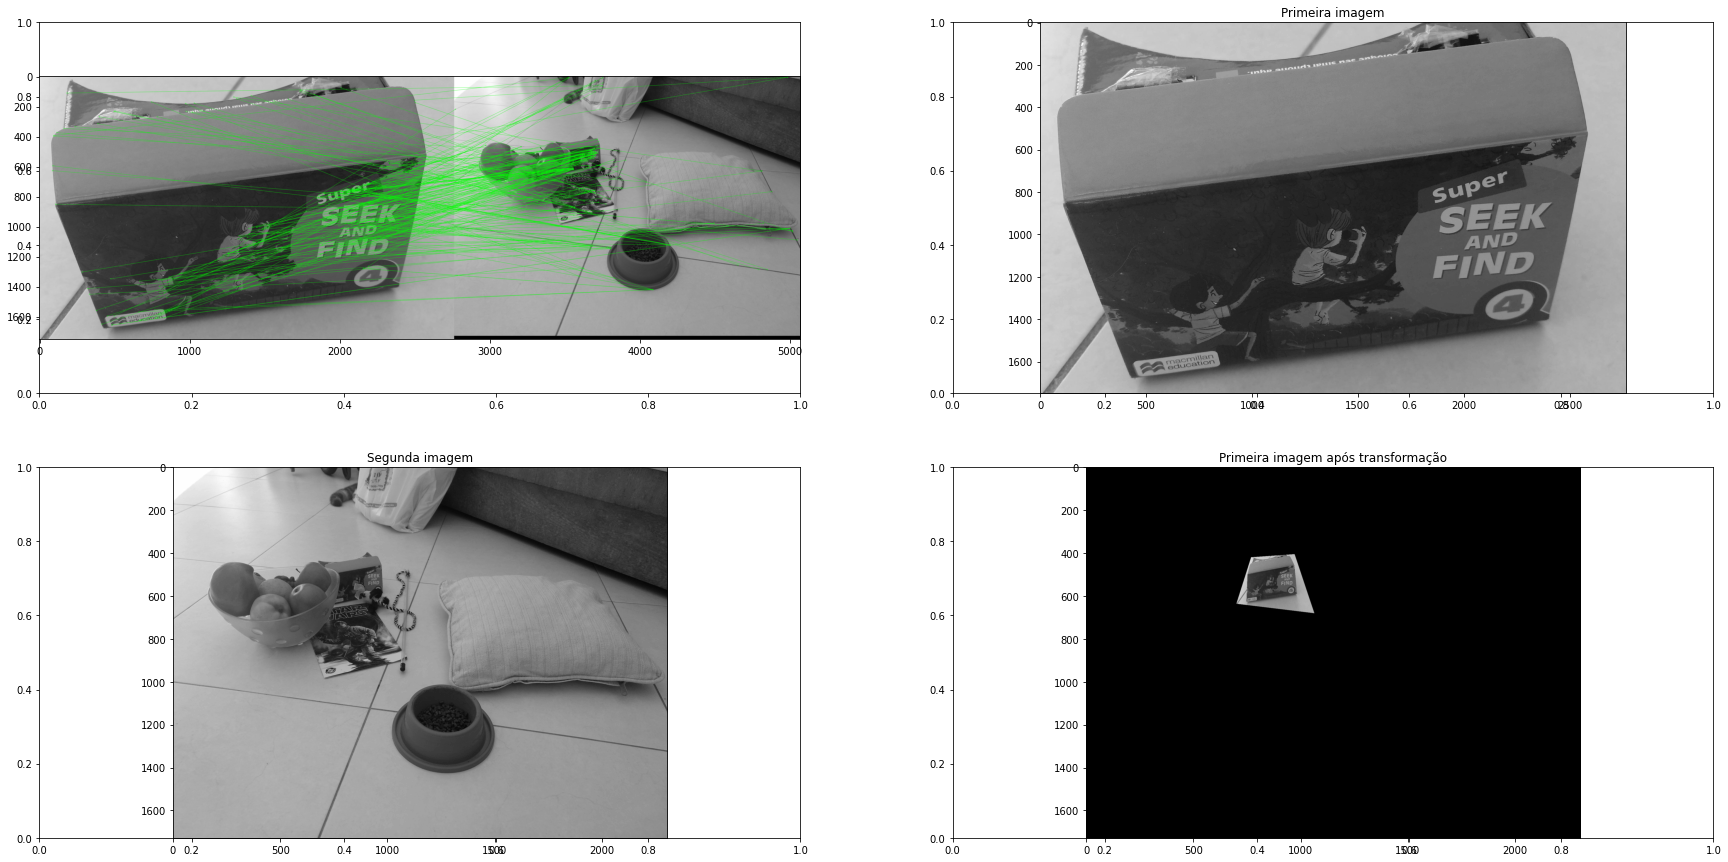

In [9]:
MIN_MATCH_COUNT = 10
img1 = cv.imread('/content/drive/MyDrive/Visão Computacional/Trabalho 2/imagens/box.jpg', 0)   # queryImage
img2 = cv.imread('/content/drive/MyDrive/Visão Computacional/Trabalho 2/imagens/photo01a.jpg', 0)        # trainImage

# Inicialização do SIFT
sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)


# FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1, 1, 2)
    
    #################################################
    M = Homografia(src_pts,dst_pts) # AQUI ENTRA A SUA FUNÇÃO DE HOMOGRAFIA!!!!

    #M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    #################################################

    img4 = cv.warpPerspective(img1, M, (img2.shape[1], img2.shape[0])) 

else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   flags = 2)
img3 = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

fig, axs = plt.subplots(2, 2, figsize=(30, 15))
fig.add_subplot(2, 2, 1)
plt.imshow(img3, 'gray')
fig.add_subplot(2, 2, 2)
plt.title('Primeira imagem')
plt.imshow(img1, 'gray')
fig.add_subplot(2, 2, 3)
plt.title('Segunda imagem')
plt.imshow(img2, 'gray')
fig.add_subplot(2, 2, 4)
plt.title('Primeira imagem após transformação')
plt.imshow(img4, 'gray')
plt.show()

## Resultado Esperado


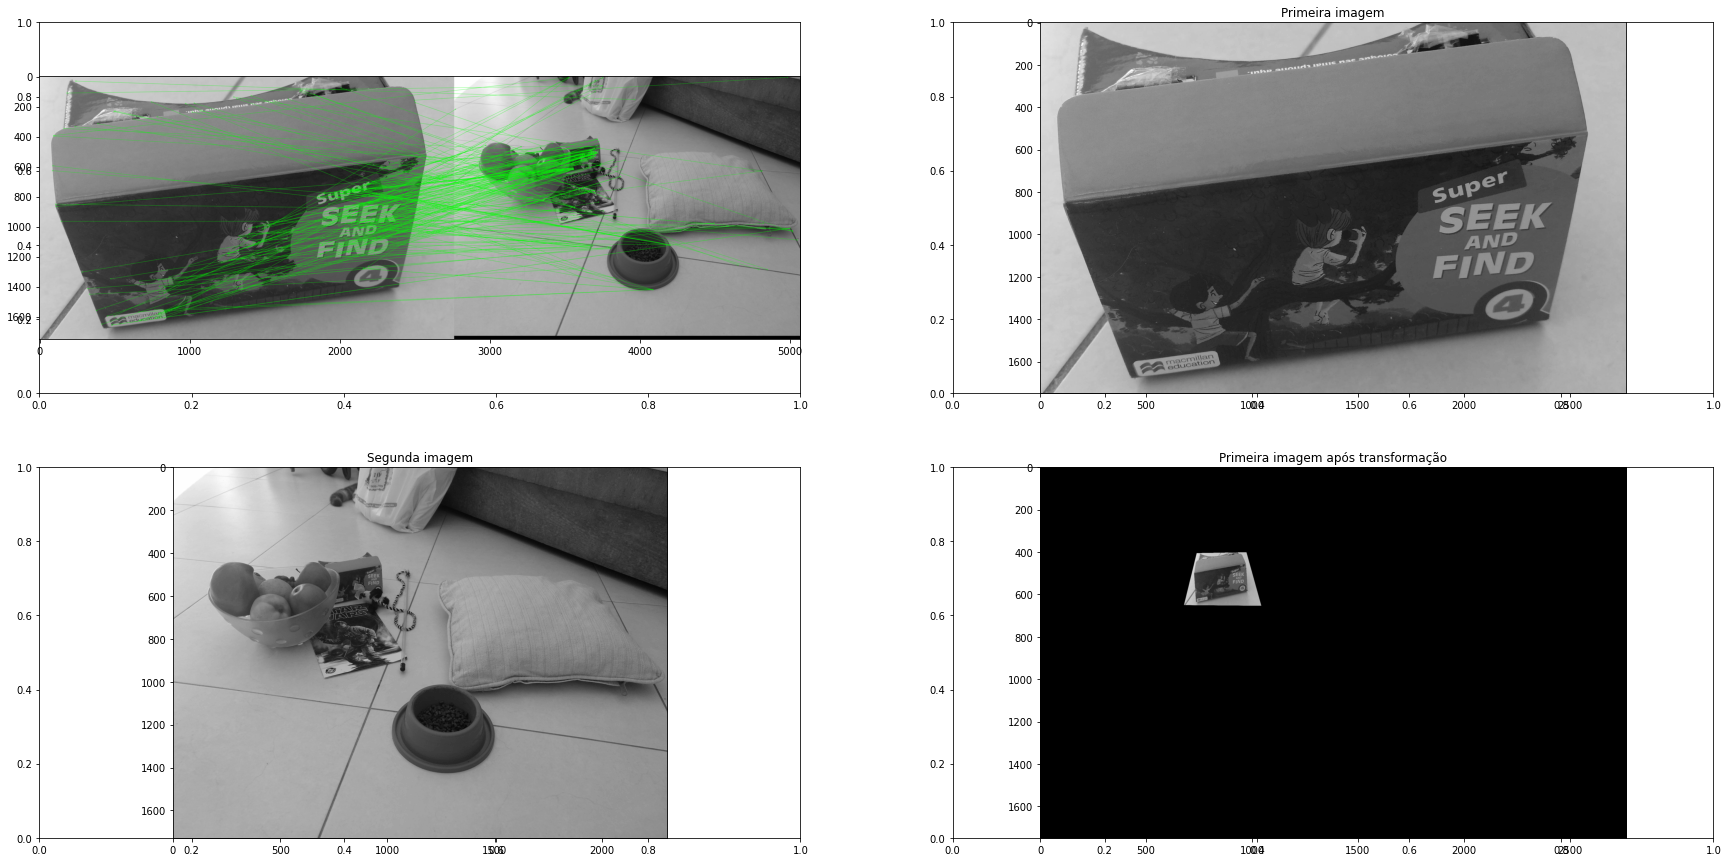

In [10]:
MIN_MATCH_COUNT = 10
img1 = cv.imread('/content/drive/MyDrive/Visão Computacional/Trabalho 2/imagens/box.jpg', 0)   # queryImage
img2 = cv.imread('/content/drive/MyDrive/Visão Computacional/Trabalho 2/imagens/photo01a.jpg', 0)        # trainImage

# Inicialização do SIFT
sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)


# FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1, 1, 2)
    
    #################################################
    #M = Homografia(src_pts,dst_pts) # AQUI ENTRA A SUA FUNÇÃO DE HOMOGRAFIA!!!!
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    #################################################

    img4 = cv.warpPerspective(img1, M, (img1.shape[1], img1.shape[0])) 

else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   flags = 2)
img3 = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

fig, axs = plt.subplots(2, 2, figsize=(30, 15))
fig.add_subplot(2, 2, 1)
plt.imshow(img3, 'gray')
fig.add_subplot(2, 2, 2)
plt.title('Primeira imagem')
plt.imshow(img1, 'gray')
fig.add_subplot(2, 2, 3)
plt.title('Segunda imagem')
plt.imshow(img2, 'gray')
fig.add_subplot(2, 2, 4)
plt.title('Primeira imagem após transformação')
plt.imshow(img4, 'gray')
plt.show()